In [92]:
import sys

sys.path.append('../src')

from swfilter import SlicedWassersteinFilter

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.io import arff
import mlflow
import seaborn as sns


First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [135]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# Create a new MLflow Experiment
experiment_id = "swfilter_nocv"
experiment = mlflow.set_experiment(experiment_id)

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Experiment_id: 364790353758562985
Artifact Location: mlflow-artifacts:/364790353758562985
Name: swfilter_nocv
Tags: {}
Lifecycle_stage: active


In [95]:
def import_dataset(folder_name:str, dataset_name:str)->pd.DataFrame:
    arff_file = arff.loadarff(f'../datasets/{folder_name}/{dataset_name}.arff')
    df_file = pd.DataFrame(arff_file[0])
    features = df_file.drop(columns=['outlier', 'id'])
    label = df_file['outlier']
    return features, label, df_file
    

In [188]:
#features, label, data = import_dataset('Lymphography', 'Lymphography_withoutdupl_norm_idf')
dataset_name = 'Pima'
dataset_precise_name = 'Pima_withoutdupl_norm_35'
features, label, data = import_dataset(dataset_name, dataset_precise_name)
X = np.array(features.values)
y = np.array(label.values == b'yes')
y = np.where(y, -1, 1)
display(y.shape)



(768,)

## hyperopt

In [189]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, make_scorer
from functools import partial
import mlflow

# Define search spaces
space_lof = {
    'n_neighbors': hp.quniform('n_neighbors', 5, 50,1),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'leaf_size': hp.quniform('leaf_size', 5, 50, 1),
    'metric': hp.choice('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
}

space_forest = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_samples': hp.quniform('max_samples', 1, X.shape[1],1),
    'contamination': hp.loguniform('contamination', -7, -0.70),
    'max_features': hp.quniform('max_features', 1, X.shape[1], 1)
}

space_sw = {
    'eps': hp.loguniform('eps', -7, 1),
    'n': hp.quniform('n', 10, 50, 1),
    'n_projections': hp.quniform('n_projections', 10, 200, 1),
    'p': hp.uniform('p', 0.7, 1)
}




# Adjusting the objective functions to include cross-validation on training data and evaluation on testing data

def objective_lof(space, X_train, Y_train, X_test, Y_test, scoring, experiment_id, dataset_name, cv):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_neighbors = int(space['n_neighbors'])
        algorithm = space['algorithm']
        leaf_size = int(space['leaf_size'])
        metric = space['metric']
        
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            novelty=True
        )
        
        # Cross-validation on training data
        cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
    

        # Fit the model on the entire training dataset
        model.fit(X_train)
        
        # Evaluate on the testing data
        Y_pred = model.predict(X_test)
        test_score = scoring(model, X_test, Y_test)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_neighbors", n_neighbors)
        mlflow.log_param("algorithm", algorithm)
        mlflow.log_param("leaf_size", leaf_size)
        mlflow.log_param("metric", metric)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_metric("cv_score", cv_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.set_tag("model", "LocalOutlierFactor")
        
        return {'loss': -cv_score, 'status': STATUS_OK}

def objective_forest(space, X_train, Y_train, X_test, Y_test, scoring, experiment_id, dataset_name, cv):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_estimators = int(space['n_estimators'])
        max_samples = int(space['max_samples'])
        contamination = space['contamination']
        max_features = int(space['max_features'])
        
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=42
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_train)
        cv_score = scoring(model, X_train, Y_train)
        
        # Fit the model on the entire training dataset
        # model.fit(X_train)
        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_score = scoring(model, X_test, Y_test)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_samples", max_samples)
        mlflow.log_param("contamination", contamination)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_metric("cv_score", cv_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.set_tag("model", "IsolationForest")
        
        return {'loss': -cv_score, 'status': STATUS_OK}
    

def objective_sw(space, X_train, Y_train, X_test, Y_test, scoring, experiment_id, dataset_name, cv):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        eps = float(space['eps'])
        n = int(space['n'])
        n_projections = int(space['n_projections'])
        p = float(space['p'])
        
        
        model = SlicedWassersteinFilter(
            eps=eps,
            n=n,
            n_projections=n_projections,
            p=p,
            seed=42,
            n_jobs=-1,
            swtype='original'  # Assuming a seed parameter is available for reproducibility
        )
        
        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_train)
        cv_score = scoring(model, X_train, Y_train)
        

        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_test)
        
        
        test_score = scoring(model, X_test, Y_test)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("eps", eps)
        mlflow.log_param("n", n)
        mlflow.log_param("n_projections", n_projections)
        mlflow.log_param("p", p)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_metric("cv_score", cv_score)
        mlflow.log_metric("test_score", test_score)
        mlflow.set_tag("model", "SlicedWassersteinFilter")
        
        return {'loss': -cv_score, 'status': STATUS_OK}



In [190]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, y, test_size=0.5, random_state=42)
cv = 5

In [191]:
lof_bool = True
forest_bool = True
sw_bool = True

In [192]:
# Example of using partial to create a function with pre-filled parameters
# Create a precision scorer object
scoring = make_scorer(precision_score, zero_division=0)

max_evals = 100
if lof_bool:
    # Example of running a trial for LOF with the partial function
    objective_lof_partial = partial(objective_lof, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, scoring=scoring, experiment_id=experiment_id, dataset_name=dataset_name, cv=cv)

    trials_lof = Trials()
    best_lof = fmin(fn=objective_lof_partial,
                    space=space_lof,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials_lof)

if forest_bool:
    objective_forest_partial = partial(objective_forest, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, scoring=scoring, experiment_id=experiment_id, dataset_name=dataset_name, cv=cv)

    trials_iforest = Trials()
    best_iforest = fmin(fn=objective_forest_partial,
                        space=space_forest,
                        algo=tpe.suggest,
                        max_evals=max_evals,
                        trials=trials_iforest)

if sw_bool:
    objective_sw_partial = partial(objective_sw, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, scoring=scoring, experiment_id=experiment_id, dataset_name=dataset_name, cv=cv)

    # Example of running a trial for SlicedWassersteinFilter with the partial function
    trials_sw = Trials()
    best_sw = fmin(fn=objective_sw_partial,
                space=space_sw,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials_sw)

100%|██████████| 100/100 [3:19:44<00:00, 119.84s/trial, best loss: -0.8209876543209876] 


## Extract results

In [193]:
df = mlflow.search_runs([experiment.experiment_id],filter_string="status = 'FINISHED'")
#building_ids = df['params.building_id']
display(df)
datasets = df['params.dataset_name'].unique()
print(datasets)
models = ['SlicedWassersteinFilter', 'IsolationForest', 'LocalOutlierFactor']

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_score,metrics.cv_score,params.p,params.eps,...,params.max_features,params.n_neighbors,params.leaf_size,params.algorithm,params.metric,tags.model,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user
0,8d8f33fea4464a149fe809b5f30d380f,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/8d8f33fea...,2024-08-02 06:23:12.379000+00:00,2024-08-02 06:25:40.452000+00:00,0.661458,0.640625,0.9148731312542341,0.0065841412898907685,...,None,None,None,None,None,SlicedWassersteinFilter,upbeat-sow-895,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
1,e4b8aaab90f44cd3b4c830cb9ad7eb43,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/e4b8aaab9...,2024-08-02 06:22:34.807000+00:00,2024-08-02 06:23:12.358000+00:00,0.661458,0.640625,0.8127087410191121,0.4274877357511799,...,None,None,None,None,None,SlicedWassersteinFilter,righteous-rat-493,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
2,4245b389ba8c4e44a0c39e1d185d2799,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/4245b389b...,2024-08-02 06:21:26.914000+00:00,2024-08-02 06:22:34.782000+00:00,0.664042,0.642298,0.7481353286174118,0.0038495063421522873,...,None,None,None,None,None,SlicedWassersteinFilter,skillful-snipe-339,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
3,169570e4b02f4bd5a5b5a28bd8716842,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/169570e4b...,2024-08-02 06:19:08.604000+00:00,2024-08-02 06:21:26.887000+00:00,0.661458,0.640625,0.9020449169788491,0.21383378552229812,...,None,None,None,None,None,SlicedWassersteinFilter,grandiose-goose-535,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
4,66675a0b46d1496abd592090f6700219,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/66675a0b4...,2024-08-02 06:16:26.974000+00:00,2024-08-02 06:19:08.576000+00:00,0.661247,0.654054,0.8268644334701462,0.00216554827683368,...,None,None,None,None,None,SlicedWassersteinFilter,righteous-eel-223,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,43eae16b79dc43cfa1a347c76957f3d2,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/43eae16b7...,2024-08-01 17:57:29.286000+00:00,2024-08-01 17:57:29.372000+00:00,0.836207,0.789222,None,None,...,None,21,11,kd_tree,manhattan,LocalOutlierFactor,mercurial-fox-879,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
1997,a5022e32673649729b7d3b1354adc096,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/a5022e326...,2024-08-01 17:57:29.201000+00:00,2024-08-01 17:57:29.273000+00:00,0.911765,0.884182,None,None,...,None,6,9,ball_tree,euclidean,LocalOutlierFactor,illustrious-lark-924,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
1998,5ca1e70c81da4cf595ce7e9087b26300,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/5ca1e70c8...,2024-08-01 17:57:29.103000+00:00,2024-08-01 17:57:29.189000+00:00,0.918367,0.870747,None,None,...,None,19,29,ball_tree,chebyshev,LocalOutlierFactor,glamorous-wren-527,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage
1999,a1aca2ef065c4a8aa838da67878a9ae8,364790353758562985,FINISHED,mlflow-artifacts:/364790353758562985/a1aca2ef0...,2024-08-01 17:57:28.992000+00:00,2024-08-01 17:57:29.088000+00:00,0.836207,0.789295,None,None,...,None,17,11,brute,manhattan,LocalOutlierFactor,omniscient-hare-439,LOCAL,/Users/julienpallage/anaconda3/lib/python3.10/...,julienpallage


['Pima' 'WPBC' 'Shuttle' 'Glass' 'Lymphography' 'Ionosphere']


In [194]:
import json
result_dict = {}

for dataset in datasets:
    for model in models:
        best_val= df.loc[(df['params.dataset_name'] == dataset) & (df['tags.model'] == model)].sort_values(by=['metrics.cv_score', 'end_time'], ascending=False).head(1)

        #best_mse = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MSE_val', ascending=True).head(1)
        #best_build = df.loc[ (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_VAL_all_buildings_scaled', ascending=True).head(1)

        if f'{dataset}' not in result_dict.keys():
            result_dict[f'{dataset}'] = {}

       
        result_dict[f'{dataset}'][f'{model}'] = {'test_score': best_val['metrics.test_score'].values[0]}



In [195]:
df_2 = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in result_dict.items()
    }, 
    axis=0)

In [196]:

metrics = ['test_score']

data = pd.DataFrame(columns=datasets, index=models)

for ids in datasets:
        for model in models:
                if ids in df_2['test_score'] and model and ids is not None:
                        data[ids][model] = df_2['test_score'][ids][model]
                

                


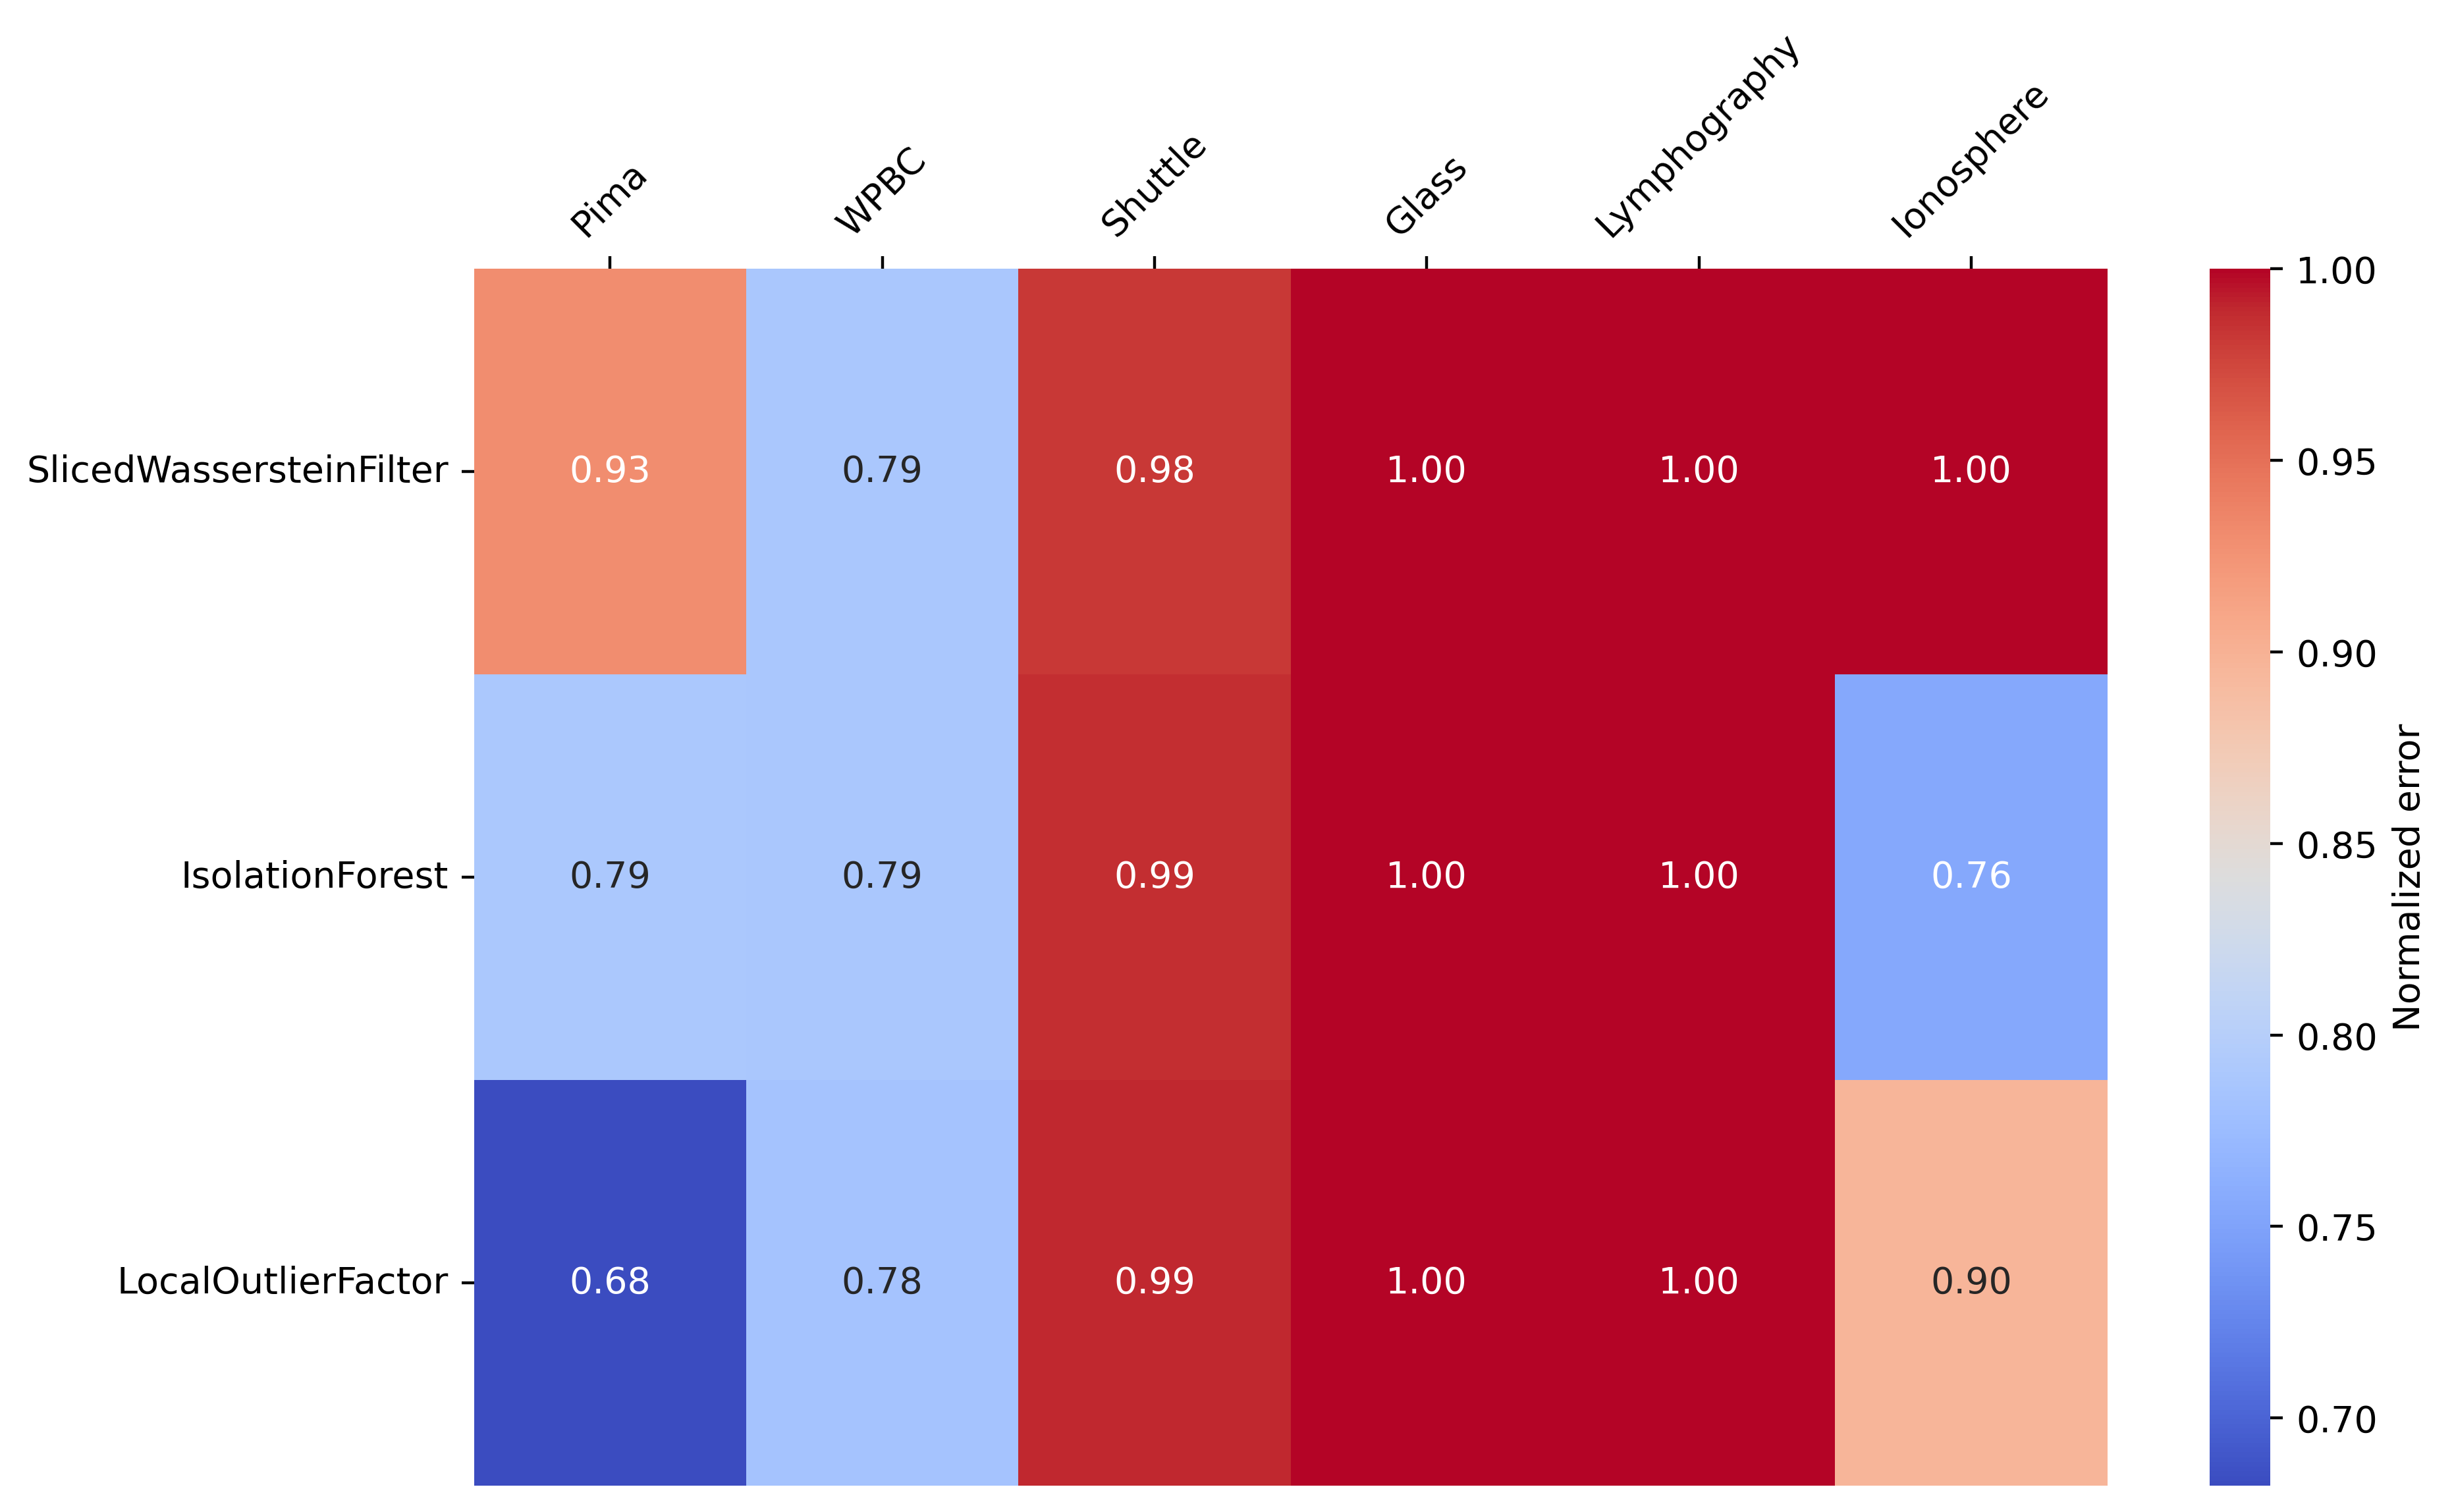

In [197]:
# Normalize each column by its range
data_norm = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Normalized error'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('heatmap_JOPT.pdf', bbox_inches='tight')
plt.show()